<a href="https://colab.research.google.com/github/ftornay/TFG/blob/master/A/IAPS_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from pathlib import Path

In [ ]:
# Activar drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/IAPS

In [ ]:
# Usamos el objeto Path de Python para guardar la ruta de los archivos
iaps_path = Path("/content/drive/MyDrive/IAPS")
iaps_imgs = iaps_path/"Imágenes"
iaps_imgs

In [ ]:
import glob # Para encontrar archivos
xls_files = glob.glob(str(iaps_path) + "/*.xls")
# Todos los archivos excel
# Contienen los datos de valencia, activación y dominancia
xls_files

In [ ]:
# Leemos los ficheros excel usando pandas
dfs = []
for fn in xls_files:
  dfs.append(pd.read_excel(fn))
# Mostramos el comienzo del primer archivo
dfs[0].head()

In [ ]:
# Al parecer los encabezados se repiten de vez en cuando
# Por ejemplo
dfs[0][dfs[0].iloc[:,0] == 'Nº']

In [ ]:
# Unimos los ficheros en un solo dataframe
iaps_data = pd.concat(dfs)
# Y lo limpiamos

# Damos nombre a las columnas
columnas = ['imagen', 'descripcion', 'conjunto',
            'val.media.total', 'val.dt.total', 'ar.media.total', 'ar.dt.total', 'dom.media.total', 'dom.dt.total',
            'val.media.hombres', 'val.dt.hombres', 'ar.media.hombres', 'ar.dt.hombres', 'dom.media.hombres', 'dom.dt.hombres',
            'val.media.mujeres', 'val.dt.mujeres', 'ar.media.mujeres', 'ar.dt.mujeres', 'dom.media.mujeres', 'dom.dt.mujeres',
            ]
iaps_data.columns = columnas
# Eliminamos los encabezados
# Son filas que o bien comienzan por NaN (valor nulo)
# O por "Nº"
# Eliminamos los dos tipos
iaps_data.dropna(inplace=True)
filas_no = iaps_data[iaps_data.iloc[:,0]=='Nº'].index
iaps_data.drop(filas_no, inplace=True) 
# Quitamos las filas con imágenes duplicadas
# El primer fichero se llama "Jaime" y el segundo "NORMAS1"
# Por si acaso, me quedo mejor con el segundo
# Por eso pongo keep='last'
iaps_data.drop_duplicates(subset='imagen', keep='last', inplace=True)
# Convertimos los números de imagen a cadenas
# sin espacios
iaps_data['imagen'] = iaps_data['imagen'].astype(str).str.strip()
# Y usamos el número de imagen como índice
# lo que permite buscar más rápido las imágenes, ordenarlas, etc.
iaps_data.set_index('imagen', inplace=True)
# Convertimos los datos a números reales
for col in range(2, 20):
    iaps_data.iloc[:, col] = iaps_data.iloc[:, col].astype('float64')
# Ver los datos limpios
iaps_data.head(10)

In [ ]:
# Tamaño de los datos limpios
iaps_data.shape

In [ ]:
# Ahora buscamos todos los archivos de imágenes, que están dispersos por varios subdirectorios
import os # Librería Python para conectar con el sistema operativo
img_files = []
# La funcion os.walk "pasea" por todos los directorios
# La usamos para encontrar todos los ficheros jpg
for root, dirs, files in os.walk(iaps_imgs):
    for fn in files:
        # Extraemos la extensión del archivo
        base, ext = os.path.splitext(fn)
        if ext.lower() in ['.jpg', '.jpeg']:
            # Ruta absoluta
            path = os.path.join(root, fn)
            # Ruta relativa (como pide fastai)
            path = os.path.relpath(path, iaps_path)
            img_files.append(path)
# ¿Cuántas hay? Comparar con las filas de datos
len(img_files)

In [ ]:
def num_imagen(fn):
  """ Función que devuelve el número de imagen a partir de su nombre de archivo """
  # Nombre de archivo base, sin la ruta de directorios
  fn_base = os.path.basename(fn)
  # Al nombre base le quitamos la extensión
  num = os.path.splitext(fn_base)[0]
  # En los datos, en vez de un guion hay un punto
  num = num.replace('_', '.')
  return num

In [ ]:
# img_files contiene una lista de nombres de archivo
# con toda la ruta hasta su directorio
# Las tablas de excel se refieren solo al número de la imagen
# Por eso, hacemos un diccionario que convierta del número al archivo
imgs_dir = {}
for fn in img_files:
  # Tomamos el número de la imagen
  numero_img = num_imagen(fn)
  # En el diccionario almacenamos la ruta completa
  # conectándola con el número
  imgs_dir[numero_img] = fn
# El diccionario asegura que no haya imágenes repetidas,comprobar cuántas hay
len(imgs_dir)

In [ ]:
# Ver diccionario
imgs_dir

In [ ]:
# ¿Qué imágenes de los datos no están en archivo?
datos_faltan = []
for index, _ in iaps_data.iterrows():
  if index not in imgs_dir:
    datos_faltan.append(index)
len(datos_faltan), datos_faltan

In [ ]:
# Eliminamos el único dato del que no tenemos imagen
iaps_data.drop(index=datos_faltan[0], inplace=True)

In [ ]:
# Y al revés,
# ¿qué imágenes de archivo no están en los datos?
imgs_faltan = []
for img in imgs_dir:
  if img not in iaps_data.index:
    imgs_faltan.append(img)
len(imgs_faltan), imgs_faltan

(18,
 ['2100',
  '2660',
  '3220',
  '4531',
  '4617',
  '5200',
  '5740',
  '5870',
  '6560',
  '7140',
  '7235',
  '7495',
  '7501',
  '7640',
  '8501',
  '9042',
  '7038',
  '310.1'])

In [ ]:
# Borramos las rutas de las imágenes que no están en los datos
for i in imgs_faltan:
  del imgs_dir[i]
# Comprobamos que ahora coinciden los datos y las imágenes
len(imgs_dir) == iaps_data.shape[0]

True

In [ ]:
# ¿Y cuántos son por fin los datos correctos?
iaps_data.shape

(806, 20)

In [ ]:
# Ponemos la ruta a cada imagen como parte de los datos
iaps_data['ruta_img'] = iaps_data.index.map(imgs_dir)

Imágenes/SET1_14.zip (Unzipped Files)/SET_14/8485.JPG
(1024, 768)


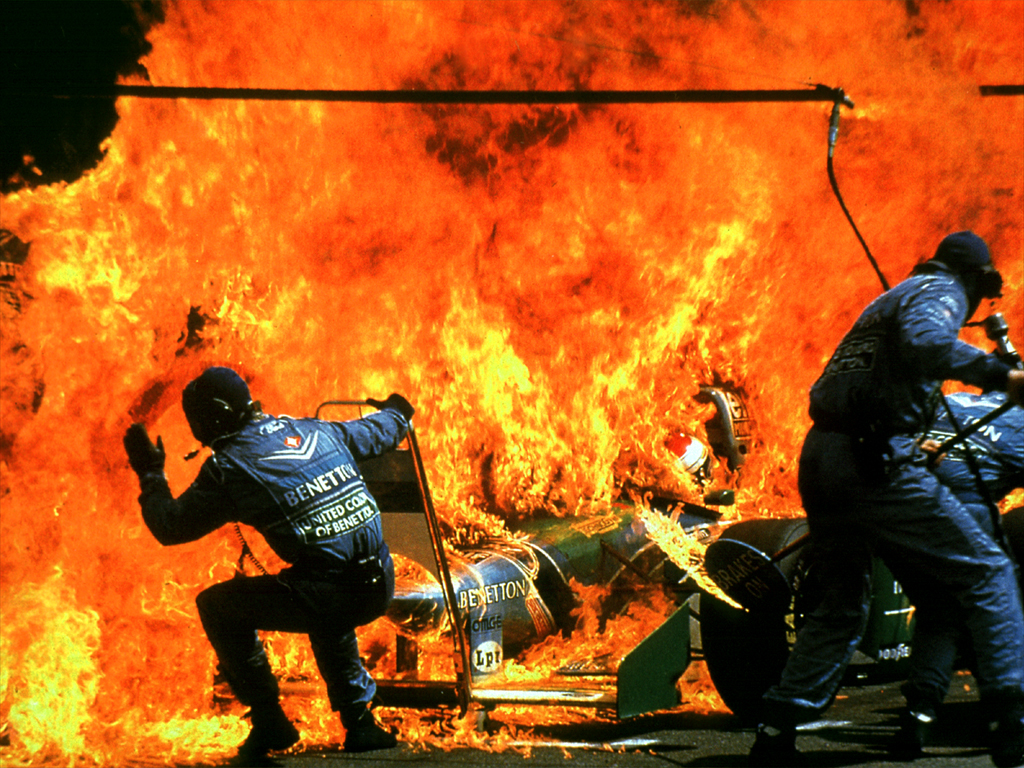

In [ ]:
import PIL
# Índice de una imagen cualquiera
# Cambiar para ver otras
ind = 815
# Fichero
print(img_files[ind])
# Abrirla y mostrarla
image = PIL.Image.open(iaps_path/img_files[ind])
print(image.size)
image

In [ ]:
# Consultamos los datos correspondientes a esa imagen
num = num_imagen(img_files[ind])
iaps_data.loc[num, :]

descripcion                                                      Fuego
conjunto                                                            14
val.media.total                                                   2.49
val.dt.total                                                      1.53
ar.media.total                                                    7.31
ar.dt.total                                                       1.87
dom.media.total                                                   2.72
dom.dt.total                                                      1.73
val.media.hombres                                                 3.18
val.dt.hombres                                                    1.66
ar.media.hombres                                                  7.03
ar.dt.hombres                                                     2.09
dom.media.hombres                                                 3.32
dom.dt.hombres                                                     1.8
val.me

In [ ]:
# Por fin, grabamos los datos limpios en disco
iaps_data.to_pickle(iaps_path/'iaps_data.pkl')